# **2. Fine-Grained Classification**

**Project Setup Guide**

1. Unzipping and Uploading the Project

  - Unzip the `Coursework_chatwipa.zip` file.
  - Upload the extracted folder to your Google Drive, maintaining the following structure:

```
drive
|- Coursework_chatwipa
|  |- TASK 1
|  |- TASK 2
|  |  |- Model
|  |  |  |- task2_best_model2.keras
|  |  |  |- task2_best_model3.keras
|  |  |  |- task2_best_model6.keras
|  |  |- TASK2.ipynb
|  |
|  |- TASK 3
```

2. Uploading Additional Data

    - Place the dataset zip files (`bird_CUB_200_2011.zip`) into the `TASK 2` folder.
    - The final folder structure should be:

```
drive
|- Coursework_chatwipa
|  |- TASK 1
|  |- TASK 2
|  |  |- Model
|  |  |  |- task2_best_model2.keras
|  |  |  |- task2_best_model3.keras
|  |  |  |- task2_best_model6.keras
|  |  |- TASK2.ipynb
|  |  |- bird_CUB_200_2011.zip
|  |
|  |- TASK 3
```

3. Running the Demonstration

  - Navigate to the **Demonstration** section of the notebook to test the process before proceeding further.

Install Library

In [ ]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.9 MB/s eta 0:00:00


In [ ]:
import os
import zipfile
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import EfficientNetB2, DenseNet121
from tensorflow.keras.optimizers import Adagrad, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import keras_tuner as kt

## 1. Load dataset


In [ ]:
# Mount the drive with google colab notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
dataset_zip = "/content/drive/MyDrive/Deep learning dataset/bird_CUB_200_2011.zip"

In [ ]:
# Unzip dataset from drive to disk
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/")

In [ ]:
# Read train and test label from .txt file
train_test_label = "/content/CUB_200_2011/train_test_split.txt"
split_label = pd.read_csv(train_test_label, header = None, delimiter=' ')
split_label.columns = ['label', 'is_train']

# Read the map of label number and file name from .txt file
image_name_label = "/content/CUB_200_2011/images.txt"
img_label = pd.read_csv(image_name_label, header = None, delimiter=' ')
img_label.columns = ['label', 'file_name']

# Merge the two dataframes on 'file_name'
df_merged = pd.merge(split_label, img_label, on="label")
df_merged["class_name"] = df_merged["file_name"].apply(lambda x: x.split("/")[0])

# Display the result
df_merged.head()

label  is_train                                          file_name  \
0      1         0  001.Black_footed_Albatross/Black_Footed_Albatr...   
1      2         1  001.Black_footed_Albatross/Black_Footed_Albatr...   
2      3         0  001.Black_footed_Albatross/Black_Footed_Albatr...   
3      4         1  001.Black_footed_Albatross/Black_Footed_Albatr...   
4      5         1  001.Black_footed_Albatross/Black_Footed_Albatr...   

                   class_name  
0  001.Black_footed_Albatross  
1  001.Black_footed_Albatross  
2  001.Black_footed_Albatross  
3  001.Black_footed_Albatross  
4  001.Black_footed_Albatross

## 2. Train/Test/Validation segmentation

1. Randomly separate into 90% train set and 10% validation set
2. Copy the image into destination folder

**Folder structure:**
```
/content/
|- train_images
|  |- 01. Class01
|  |- 02. Class02
|  |- ...
|- validation_images
|  |- 01. Class01
|  |- 02. Class02
|  |- ...
|- test_images
|  |- 01. Class01
|  |- 02. Class02
|  |- ...
```

In [ ]:
# Function to randomly select the validation data
# (make sure that all classes have validation data)
def pick_validation(group, val_ratio = 0.1):
    n_val = max(1, int(len(group) * val_ratio)) # number of total validation number
    val_indices = np.random.choice(group.index, size=n_val, replace=False) # randomly select the index by group
    group.loc[val_indices, "is_val"] = 1 # change the label from 0 (False) to 1 (True)
    return group

df_merged["is_val"] = 0 # Setting initial label to be 0 (False)
df_merged = df_merged.groupby("class_name", group_keys=False).apply(pick_validation) # group by class and select validaion data

# Show first five rows
df_merged.head()

<ipython-input-6-3e515e2281a6>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_merged = df_merged.groupby("class_name", group_keys=False).apply(pick_validation) # group by class and select validaion data


label  is_train                                          file_name  \
0      1         0  001.Black_footed_Albatross/Black_Footed_Albatr...   
1      2         1  001.Black_footed_Albatross/Black_Footed_Albatr...   
2      3         0  001.Black_footed_Albatross/Black_Footed_Albatr...   
3      4         1  001.Black_footed_Albatross/Black_Footed_Albatr...   
4      5         1  001.Black_footed_Albatross/Black_Footed_Albatr...   

                   class_name  is_val  
0  001.Black_footed_Albatross       0  
1  001.Black_footed_Albatross       0  
2  001.Black_footed_Albatross       0  
3  001.Black_footed_Albatross       0  
4  001.Black_footed_Albatross       0

In [ ]:
# List of related folder for this project
original_folder = "/content/CUB_200_2011/images/"
train_folder = '/content/train_images/'
test_folder = '/content/test_images/'
validate_folder = '/content/validate_images/'

# Create train and test folders if not exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)
os.makedirs(validate_folder, exist_ok=True)

# Loop through each row and move images to the correct folder
for _, row in df_merged.iterrows():
    class_name = row["class_name"]
    source_path = os.path.join(original_folder, row["file_name"])

    # Define destination folder based on is_train and is_val flag
    if row["is_train"] == 1:
      if row["is_val"] == 1:
        dest_folder = os.path.join(validate_folder, class_name)
      else:
        dest_folder = os.path.join(train_folder, class_name)
    else:
        dest_folder = os.path.join(test_folder, class_name)

    # Create class-specific subfolder if it doesn't exist
    os.makedirs(dest_folder, exist_ok=True)

    # Copy image to new location
    dest_path = os.path.join(dest_folder, os.path.basename(row["file_name"]))
    shutil.copy(source_path, dest_path)

## 3. Model Training

### 3.1 EfficientNetB2

**Data Preprocessing**
- Resize input shape to (260, 260, 3) for DenseNet121

In [ ]:
# Image data generator for train data (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

# Train generator (90% of data)
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(260, 260),
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    subset="training"
)

# Image data generator for validation and test set (without augmentation)
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

# Validation generator (10% of data)
validation_generator = test_datagen.flow_from_directory(
    train_folder,
    target_size=(260, 260),
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    subset="validation"
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(260, 260),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

# Check one batch of images and labels
images, labels = next(train_generator)

print(f"Batch shape: {images.shape}")  # (batch_size, 224, 224, 3)
print(f"Labels shape: {labels.shape}")  # (batch_size, num_classes)

Found 5005 images belonging to 200 classes.
Found 402 images belonging to 200 classes.
Found 5794 images belonging to 200 classes.
Batch shape: (32, 260, 260, 3)
Labels shape: (32, 200)


**Check batch from generator**

In [ ]:
class_label = df_merged["class_name"].unique()
print(class_label)

['001.Black_footed_Albatross' '002.Laysan_Albatross' '003.Sooty_Albatross'
 '004.Groove_billed_Ani' '005.Crested_Auklet' '006.Least_Auklet'
 '007.Parakeet_Auklet' '008.Rhinoceros_Auklet' '009.Brewer_Blackbird'
 '010.Red_winged_Blackbird' '011.Rusty_Blackbird'
 '012.Yellow_headed_Blackbird' '013.Bobolink' '014.Indigo_Bunting'
 '015.Lazuli_Bunting' '016.Painted_Bunting' '017.Cardinal'
 '018.Spotted_Catbird' '019.Gray_Catbird' '020.Yellow_breasted_Chat'
 '021.Eastern_Towhee' '022.Chuck_will_Widow' '023.Brandt_Cormorant'
 '024.Red_faced_Cormorant' '025.Pelagic_Cormorant' '026.Bronzed_Cowbird'
 '027.Shiny_Cowbird' '028.Brown_Creeper' '029.American_Crow'
 '030.Fish_Crow' '031.Black_billed_Cuckoo' '032.Mangrove_Cuckoo'
 '033.Yellow_billed_Cuckoo' '034.Gray_crowned_Rosy_Finch'
 '035.Purple_Finch' '036.Northern_Flicker' '037.Acadian_Flycatcher'
 '038.Great_Crested_Flycatcher' '039.Least_Flycatcher'
 '040.Olive_sided_Flycatcher' '041.Scissor_tailed_Flycatcher'
 '042.Vermilion_Flycatcher' '043.Ye

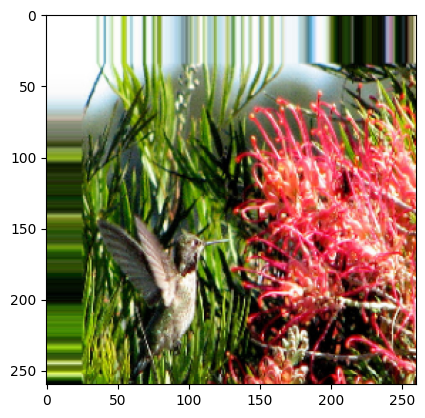

Label: 067.Anna_Hummingbird


In [ ]:
# Check a batch from the generator
batch_images, batch_labels = next(train_generator)
indices = np.where(batch_labels[0] == 1)[0]

# Display the first image and label
plt.imshow(batch_images[0])
plt.show()

print(f"Label: {class_label[indices][0]}")

#### 3.1.1 Optimizer selection

Adagrad optimizer

In [ ]:
base_model = EfficientNetB2(weights="imagenet", include_top=False, input_shape=(260, 260, 3))

for layer in base_model.layers[-50:]:
    layer.trainable = True

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(512, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(200, activation="softmax")(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x)
model.summary()

# Compile model
model.compile(
    optimizer=Adagrad(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

31790344/31790344 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 260, 260, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling (Rescaling)     │ (None, 260, 260, 3)    │              0 │ input_layer[0][0]      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization             │ (None, 260, 260, 3)    │              7 │ rescaling[0][0]        │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_1 (Rescaling)   │ (None, 260, 260, 3)    │              0 │ normalization[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 261, 261, 3)    │              0 │ rescaling_1[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 130, 130, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 130, 130, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 130, 130, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 130, 130, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 130, 130, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 130, 130, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_expand    

 Total params: 66,264,257 (252.78 MB)

 Trainable params: 66,196,682 (252.52 MB)

 Non-trainable params: 67,575 (263.97 KB)

In [ ]:
# Using L4 GPU
# Dynamic change learning rate if validation loss does not improve
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Early stopping (stop if no improvement)
early_stopping = EarlyStopping(monitor="val_accuracy", patience=7, restore_best_weights=True)

# Model checkpoint (save best model)
checkpoint = ModelCheckpoint("/content/task2_best_model1.keras",
                             monitor="val_accuracy", save_best_only=True)

# Train model
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = len(train_generator),
    validation_steps = len(validation_generator),
    epochs = 60,
    callbacks=[reduce_lr, early_stopping, checkpoint]
)

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


Epoch 1/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 245s 993ms/step - accuracy: 0.0105 - loss: 6.7189 - val_accuracy: 0.0050 - val_loss: 6.8028 - learning_rate: 0.0010
Epoch 2/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 502ms/step - accuracy: 0.0183 - loss: 6.2461 - val_accuracy: 0.0050 - val_loss: 6.3748 - learning_rate: 0.0010
Epoch 3/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 82s 521ms/step - accuracy: 0.0317 - loss: 6.0630 - val_accuracy: 0.0298 - val_loss: 6.0486 - learning_rate: 0.0010
Epoch 4/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 83s 526ms/step - accuracy: 0.0524 - loss: 5.8906 - val_accuracy: 0.0571 - val_loss: 5.9342 - learning_rate: 0.0010
Epoch 5/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 514ms/step - accuracy: 0.0935 - loss: 5.6017 - val_accuracy: 0.0993 - val_loss: 5.6039 - learning_rate: 0.0010
Epoch 6/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 78s 496ms/step - accuracy: 0.1127 - loss: 5.3415 - val_accuracy: 0.0819 - val_loss: 5.5875 - learning_rate: 0.0010
Epoch 7/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 78s 498ms/step - accuracy: 0.

Adam optimizer

In [ ]:
base_model = EfficientNetB2(weights="imagenet", include_top=False, input_shape=(260, 260, 3))

for layer in base_model.layers[-50:]:
    layer.trainable = True

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(512, activation="relu", kernel_regularizer=l2(0.001))(x)
x = Dropout(0.5)(x)
x = Dense(200, activation="softmax")(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x)
model.summary()

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_1             │ (None, 260, 260, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 260, 260, 3)    │              0 │ input_layer_1[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 260, 260, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 260, 260, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 261, 261, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 130, 130, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 130, 130, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 130, 130, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 130, 130, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 130, 130, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 130, 130, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 66,264,257 (252.78 MB)

 Trainable params: 66,196,682 (252.52 MB)

 Non-trainable params: 67,575 (263.97 KB)

In [ ]:
# Using L4 GPU
# Dynamic change learning rate if validation loss does not improve
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Early stopping (stop if no improvement)
early_stopping = EarlyStopping(monitor="val_accuracy", patience=7, restore_best_weights=True)

# Model checkpoint (save best model)
checkpoint = ModelCheckpoint("/content/task2_best_model2.keras",
                             monitor="val_accuracy", save_best_only=True)

# Train model
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = len(train_generator),
    validation_steps = len(validation_generator),
    epochs = 60,
    callbacks=[reduce_lr, early_stopping, checkpoint]
)

Epoch 1/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 239s 879ms/step - accuracy: 0.0043 - loss: 8.8646 - val_accuracy: 0.0050 - val_loss: 7.2617 - learning_rate: 0.0010
Epoch 2/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 500ms/step - accuracy: 0.0033 - loss: 7.0255 - val_accuracy: 0.0025 - val_loss: 6.4508 - learning_rate: 0.0010
Epoch 3/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 79s 501ms/step - accuracy: 0.0031 - loss: 6.2992 - val_accuracy: 0.0050 - val_loss: 5.8948 - learning_rate: 0.0010
Epoch 4/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 78s 498ms/step - accuracy: 0.0034 - loss: 5.8410 - val_accuracy: 0.0050 - val_loss: 5.7160 - learning_rate: 0.0010
Epoch 5/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 78s 493ms/step - accuracy: 0.0040 - loss: 5.7706 - val_accuracy: 0.0050 - val_loss: 5.7090 - learning_rate: 0.0010
Epoch 6/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 78s 499ms/step - accuracy: 0.0061 - loss: 5.6395 - val_accuracy: 0.0050 - val_loss: 5.5009 - learning_rate: 0.0010
Epoch 7/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 78s 498ms/step - accuracy: 0.

**Conclusion**

The experiments show that Adagrad provides the best performance for this dataset as it helps stabilize training and converge efficiently. Therefore, Adagrd optimizer was used in further model training.

#### 3.1.2 Hyperparameter tuning

In [ ]:
def model_builder(hp):
    base_model = EfficientNetB2(weights="imagenet", include_top=False, input_shape=(260, 260, 3))

    # Tune the number of layers to unfreeze
    # Choose an optimal value between 40 to 100 layers
    unfreeze_layers = hp.Int('unfreeze_layers', min_value=20, max_value=60, step=20)

    # Unfreeze the last 'unfreeze_layers'
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    model = Sequential()
    model.add(base_model) #Efficientnet B2
    model.add(Flatten()) # Flatten layer
    model.add(Dense(512, activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(BatchNormalization()) # Batch normalization

    # Tune dropout rate
    # Choose an optimal value between 0.3 - 0.5
    hp_dropout = hp.Float('dropout', min_value=0.3, max_value=0.5, step=0.1)
    model.add(Dropout(hp_dropout))

    # Output layer
    model.add(Dense(200, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.001),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
# Tuning via T4 GPU
# Prepare tuner
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=40,
                     factor=3,
                     directory='/content/',
                     project_name='model3')

# Dynamic change learning rate if validation loss does not improve
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Early stopping (stop if no improvement)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

tuner.search(train_generator,
             epochs=20,
             validation_data=validation_generator,
             steps_per_epoch=len(train_generator),
             validation_steps=len(validation_generator),
             callbacks=[early_stopping, reduce_lr])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
The opimal unfreeze layers for EfficientNetB2 model is {best_hps.get('unfreeze_layers')}
The optimal dropout rate is {best_hps.get('dropout')}.
""")

Trial 9 Complete [00h 04m 34s]
val_accuracy: 0.009975062683224678

Best val_accuracy So Far: 0.01246882788836956
Total elapsed time: 00h 32m 57s

The hyperparameter search is complete.
The opimal unfreeze layers for EfficientNetB2 model is 40
The optimal dropout rate is 0.4.



Model structure

In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

best_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ efficientnetb2 (Functional)          │ (None, 9, 9, 1408)          │       7,768,569 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 114048)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      58,393,088 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 200)                 │         102,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 66,266,305 (252.79 MB)

 Trainable params: 66,197,706 (252.52 MB)

 Non-trainable params: 68,599 (267.97 KB)

#### 3.1.3 Train model using best hyperparameter

In [ ]:
base_model = EfficientNetB2(weights="imagenet", include_top=False, input_shape=(260, 260, 3))

for layer in base_model.layers[-40:]:
    layer.trainable = True

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(512, activation="relu", kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(200, activation="softmax")(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x)
model.summary()

# Compile model
model.compile(
    optimizer=Adagrad(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

Model: "functional_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2             │ (None, 260, 260, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_2 (Rescaling)   │ (None, 260, 260, 3)    │              0 │ input_layer_2[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ normalization_1           │ (None, 260, 260, 3)    │              7 │ rescaling_2[0][0]      │
│ (Normalization)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ rescaling_3 (Rescaling)   │ (None, 260, 260, 3)    │              0 │ normalization_1[0][0]  │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv_pad             │ (None, 261, 261, 3)    │              0 │ rescaling_3[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_conv (Conv2D)        │ (None, 130, 130, 32)   │            864 │ stem_conv_pad[0][0]    │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_bn                   │ (None, 130, 130, 32)   │            128 │ stem_conv[0][0]        │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ stem_activation           │ (None, 130, 130, 32)   │              0 │ stem_bn[0][0]          │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_dwconv            │ (None, 130, 130, 32)   │            288 │ stem_activation[0][0]  │
│ (DepthwiseConv2D)         │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_bn                │ (None, 130, 130, 32)   │            128 │ block1a_dwconv[0][0]   │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_activation        │ (None, 130, 130, 32)   │              0 │ block1a_bn[0][0]       │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_squeeze        │ (None, 32)             │              0 │ block1a_activation[0]… │
│ (GlobalAveragePooling2D)  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reshape        │ (None, 1, 1, 32)       │              0 │ block1a_se_squeeze[0]… │
│ (Reshape)                 │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ block1a_se_reduce         │ (None, 1, 1, 8)        │            264 │ block1a_se_reshape[0]… │
│ (Conv2D)                  │                        │                │                        │
├──────────────────────

 Total params: 66,266,305 (252.79 MB)

 Trainable params: 66,197,706 (252.52 MB)

 Non-trainable params: 68,599 (267.97 KB)

In [ ]:
# Using T4 GPU
# Dynamic change learning rate if validation loss does not improve
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Early stopping (stop if no improvement)
early_stopping = EarlyStopping(monitor="val_accuracy", patience=7, restore_best_weights=True)

# Model checkpoint (save best model)
checkpoint = ModelCheckpoint("/content/task2_best_model3.keras",
                             monitor="val_accuracy", save_best_only=True)

# Train model
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = len(train_generator),
    validation_steps = len(validation_generator),
    epochs = 80,
    callbacks=[reduce_lr, early_stopping, checkpoint]
)

Epoch 1/80
157/157 ━━━━━━━━━━━━━━━━━━━━ 199s 818ms/step - accuracy: 0.0124 - loss: 7.1249 - val_accuracy: 0.0050 - val_loss: 8.6292 - learning_rate: 0.0010
Epoch 2/80
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 509ms/step - accuracy: 0.0868 - loss: 5.7491 - val_accuracy: 0.0075 - val_loss: 7.3341 - learning_rate: 0.0010
Epoch 3/80
157/157 ━━━━━━━━━━━━━━━━━━━━ 81s 513ms/step - accuracy: 0.1658 - loss: 5.0112 - val_accuracy: 0.0449 - val_loss: 6.2742 - learning_rate: 0.0010
Epoch 4/80
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 505ms/step - accuracy: 0.2496 - loss: 4.3945 - val_accuracy: 0.2244 - val_loss: 4.6179 - learning_rate: 0.0010
Epoch 5/80
157/157 ━━━━━━━━━━━━━━━━━━━━ 77s 491ms/step - accuracy: 0.3110 - loss: 4.0188 - val_accuracy: 0.1970 - val_loss: 4.8124 - learning_rate: 0.0010
Epoch 6/80
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 507ms/step - accuracy: 0.3929 - loss: 3.6764 - val_accuracy: 0.3716 - val_loss: 3.6599 - learning_rate: 0.0010
Epoch 7/80
157/157 ━━━━━━━━━━━━━━━━━━━━ 80s 510ms/step - accuracy: 0.

Result of model

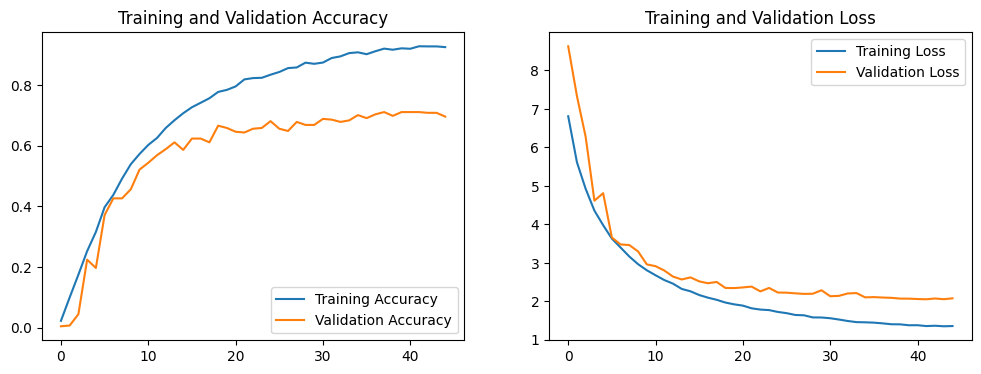

In [ ]:
import matplotlib.pyplot as plt

# Extract values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 3.1.4 Evaluation using test set

In [ ]:
# Load the saved best model
model = load_model("/content/drive/MyDrive/Coursework_chatwipa/TASK 2/Model/task2_best_model3.keras.keras")

test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


182/182 ━━━━━━━━━━━━━━━━━━━━ 50s 174ms/step - accuracy: 0.6899 - loss: 2.1679
Test Loss: 2.2340
Test Accuracy: 0.6759


In [ ]:
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels from the generator
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print(classification_report(true_classes, predicted_classes, target_names=class_labels))

182/182 ━━━━━━━━━━━━━━━━━━━━ 39s 170ms/step
                                    precision    recall  f1-score   support

        001.Black_footed_Albatross       0.73      0.73      0.73        30
              002.Laysan_Albatross       0.67      0.73      0.70        30
               003.Sooty_Albatross       0.58      0.79      0.67        28
             004.Groove_billed_Ani       0.76      0.87      0.81        30
                005.Crested_Auklet       0.86      0.86      0.86        14
                  006.Least_Auklet       1.00      0.82      0.90        11
               007.Parakeet_Auklet       0.95      0.87      0.91        23
             008.Rhinoceros_Auklet       0.47      0.78      0.58        18
              009.Brewer_Blackbird       0.42      0.34      0.38        29
          010.Red_winged_Blackbird       0.87      0.87      0.87        30
               011.Rusty_Blackbird       0.62      0.53      0.57        30
       012.Yellow_headed_Blackbird       0.

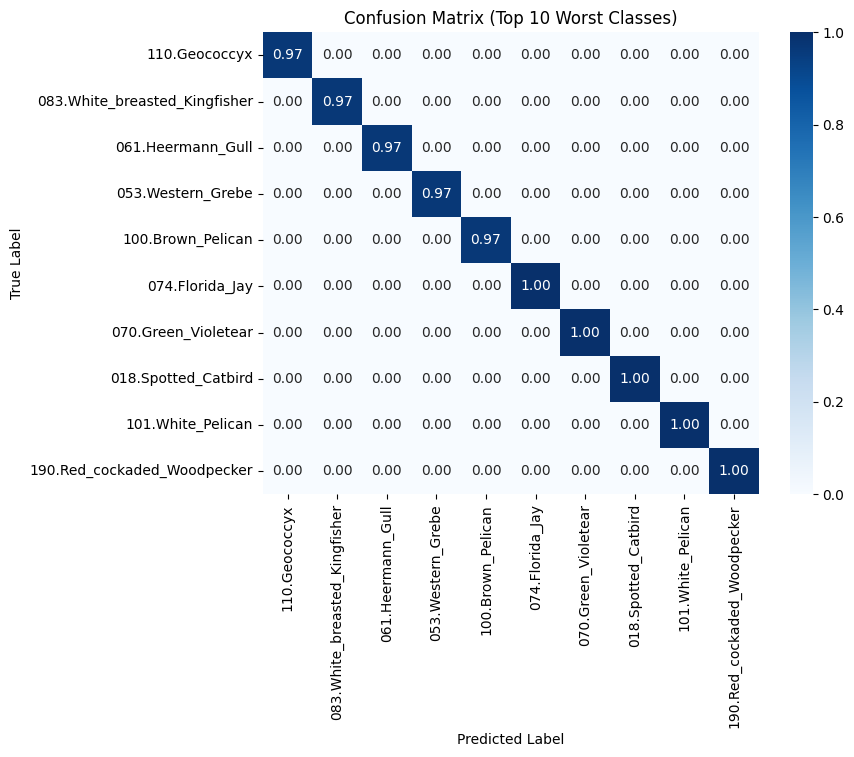

In [ ]:
# Compute confusion matrix (normalized by true class)
cm = confusion_matrix(true_classes, predicted_classes, normalize='true')

# Compute per-class TP
tp_per_class = np.diag(cm)

# Get 10 worst-performing classes (lowest recall)
top_10_classes = np.argsort(tp_per_class)[-10:]
cm_top10 = cm[np.ix_(top_10_classes, top_10_classes)]
label_top10 = [class_labels[i] for i in top_10_classes]

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_top10, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=label_top10, yticklabels=label_top10,
            vmin=0, vmax=1)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Top 10 Worst Classes)")
plt.show()

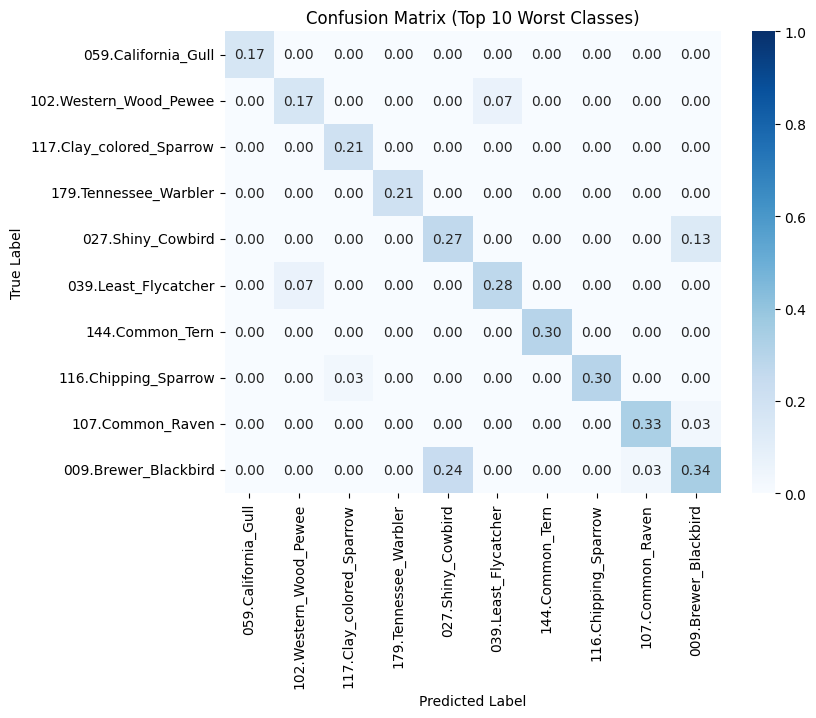

In [ ]:
# Compute confusion matrix (normalized by true class)
cm = confusion_matrix(true_classes, predicted_classes, normalize='true')

# Compute per-class TP
tp_per_class = np.diag(cm)

# Get 10 worst-performing classes (lowest recall)
worst_10_classes = np.argsort(tp_per_class)[:10]
cm_worst10 = cm[np.ix_(worst_10_classes, worst_10_classes)]
label_worst10 = [class_labels[i] for i in worst_10_classes]

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_worst10, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=label_worst10, yticklabels=label_worst10,
            vmin=0, vmax=1)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Top 10 Worst Classes)")
plt.show()

### 3.2 DenseNet121

**Data preprocessing**
- Resize input shape to (224, 224, 3) for DenseNet121

In [ ]:
# Image data generator for train data (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

# Train generator (90% of data)
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    subset="training"
)

# Image data generator for validation and test set (without augmentation)
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

# Validation generator (10% of data)
validation_generator = test_datagen.flow_from_directory(
    train_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    subset="validation"
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

# Check one batch of images and labels
images, labels = next(train_generator)

print(f"Batch shape: {images.shape}")  # (batch_size, 224, 224, 3)
print(f"Labels shape: {labels.shape}")  # (batch_size, num_classes)

Found 5005 images belonging to 200 classes.
Found 402 images belonging to 200 classes.
Found 5794 images belonging to 200 classes.
Batch shape: (32, 224, 224, 3)
Labels shape: (32, 200)


#### 3.2.1 Optimizer selection

Adagrad optimizer

In [ ]:
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[-50:]:
    layer.trainable = True

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(512, activation="relu", kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(200, activation="softmax")(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x)
model.summary()

# Compile model
model.compile(
    optimizer=Adagrad(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

Model: "functional_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_4             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 230, 230, 3)    │              0 │ input_layer_4[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 32,832,776 (125.25 MB)

 Trainable params: 32,748,104 (124.92 MB)

 Non-trainable params: 84,672 (330.75 KB)

In [ ]:
# Using L4 GPU
# Dynamic change learning rate if validation loss does not improve
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Early stopping (stop if no improvement)
early_stopping = EarlyStopping(monitor="val_accuracy", patience=7, restore_best_weights=True)

# Model checkpoint (save best model)
checkpoint = ModelCheckpoint("/content/task2_best_model4.keras",
                             monitor="val_accuracy", save_best_only=True)

# Train model
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = len(train_generator),
    validation_steps = len(validation_generator),
    epochs = 60,
    callbacks=[reduce_lr, early_stopping, checkpoint]
)

Epoch 1/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 64s 404ms/step - accuracy: 0.3983 - loss: 3.6414 - val_accuracy: 0.5486 - val_loss: 2.8034 - learning_rate: 0.0010
Epoch 2/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 64s 407ms/step - accuracy: 0.5086 - loss: 3.1617 - val_accuracy: 0.6035 - val_loss: 2.5644 - learning_rate: 0.0010
Epoch 3/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 64s 407ms/step - accuracy: 0.5883 - loss: 2.8579 - val_accuracy: 0.6484 - val_loss: 2.4345 - learning_rate: 0.0010
Epoch 4/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 63s 402ms/step - accuracy: 0.6302 - loss: 2.6530 - val_accuracy: 0.6658 - val_loss: 2.3263 - learning_rate: 0.0010
Epoch 5/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 63s 401ms/step - accuracy: 0.6744 - loss: 2.4426 - val_accuracy: 0.6758 - val_loss: 2.2553 - learning_rate: 0.0010
Epoch 6/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 63s 402ms/step - accuracy: 0.7177 - loss: 2.2650 - val_accuracy: 0.6858 - val_loss: 2.2024 - learning_rate: 0.0010
Epoch 7/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 63s 401ms/step - accuracy: 0.7

Adam optimizer

In [ ]:
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[-50:]:
    layer.trainable = True

# Add custom classification layers
x = Flatten()(base_model.output)
x = Dense(512, activation="relu", kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.4)(x)
x = Dense(200, activation="softmax")(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x)
model.summary()

# Compile model
model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_5             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_4          │ (None, 230, 230, 3)    │              0 │ input_layer_5[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_4[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_5          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_5[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 32,832,776 (125.25 MB)

 Trainable params: 32,748,104 (124.92 MB)

 Non-trainable params: 84,672 (330.75 KB)

In [ ]:
# Using L4 GPU
# Dynamic change learning rate if validation loss does not improve
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Early stopping (stop if no improvement)
early_stopping = EarlyStopping(monitor="val_accuracy", patience=7, restore_best_weights=True)

# Model checkpoint (save best model)
checkpoint = ModelCheckpoint("/content/task2_best_model5.keras",
                             monitor="val_accuracy", save_best_only=True)

# Train model
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = len(train_generator),
    validation_steps = len(validation_generator),
    epochs = 60,
    callbacks=[reduce_lr, early_stopping, checkpoint]
)

Epoch 1/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 301s 997ms/step - accuracy: 0.0086 - loss: 6.6198 - val_accuracy: 0.0175 - val_loss: 13.8189 - learning_rate: 0.0010
Epoch 2/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 64s 405ms/step - accuracy: 0.0264 - loss: 5.7377 - val_accuracy: 0.0574 - val_loss: 5.7427 - learning_rate: 0.0010
Epoch 3/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 64s 405ms/step - accuracy: 0.0705 - loss: 4.9672 - val_accuracy: 0.0723 - val_loss: 4.8160 - learning_rate: 0.0010
Epoch 4/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 61s 385ms/step - accuracy: 0.1481 - loss: 4.1839 - val_accuracy: 0.0623 - val_loss: 6.8578 - learning_rate: 0.0010
Epoch 5/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 60s 380ms/step - accuracy: 0.2235 - loss: 3.7594 - val_accuracy: 0.0424 - val_loss: 11.2088 - learning_rate: 0.0010
Epoch 6/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 63s 402ms/step - accuracy: 0.2424 - loss: 3.6312 - val_accuracy: 0.2494 - val_loss: 3.9214 - learning_rate: 0.0010
Epoch 7/60
157/157 ━━━━━━━━━━━━━━━━━━━━ 64s 403ms/step - accuracy: 

**Conclusion**

The results of the experiments indicate that Adagrad provides the best performance on this dataset, similar to the findings with EfficientNetB2. Therefore, Adagrad will be used in the further training of the model to optimize its accuracy and convergence.

#### 3.2.2 Hyperparameter Tuning

In [ ]:
def model_builder(hp):
    base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

    # Tune the number of layers to unfreeze
    # Choose an optimal value between 40 to 100 layers
    unfreeze_layers = hp.Int('unfreeze_layers', min_value=20, max_value=100, step=20)

    # Unfreeze the last 'unfreeze_layers'
    for layer in base_model.layers[-unfreeze_layers:]:
        layer.trainable = True

    model = Sequential()
    model.add(base_model) #DenseNet121
    model.add(GlobalAveragePooling2D()) # Flatten layer
    model.add(Dense(512, activation='relu',
                    kernel_regularizer=tf.keras.regularizers.l2(0.001)))
    model.add(BatchNormalization()) # Batch normalization

    # Tune dropout rate
    # Choose an optimal value between 0.3 - 0.5
    hp_dropout = hp.Float('dropout', min_value=0.3, max_value=0.5, step=0.1)
    model.add(Dropout(hp_dropout))

    # Output layer
    model.add(Dense(200, activation='softmax'))

    model.compile(optimizer=tf.keras.optimizers.Adagrad(learning_rate=0.001, clipnorm=1.0),
                  loss='categorical_crossentropy',
                  metrics=['accuracy'])

    return model

In [ ]:
# Tuning via T4 GPU
# Prepare tuner
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=40,
                     factor=3,
                     directory='/content/',
                     project_name='model6')

# Dynamic change learning rate if validation loss does not improve
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Early stopping (stop if no improvement)
early_stopping = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

tuner.search(train_generator,
             epochs=20,
             validation_data=validation_generator,
             steps_per_epoch=len(train_generator),
             validation_steps=len(validation_generator),
             callbacks=[early_stopping, reduce_lr])

# Get the optimal hyperparameters
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete.
The opimal unfreeze layers for EfficientNetB2 model is {best_hps.get('unfreeze_layers')}
The optimal dropout rate is {best_hps.get('dropout')}.
""")

Trial 15 Complete [00h 06m 19s]
val_accuracy: 0.019950125366449356

Best val_accuracy So Far: 0.03491271659731865
Total elapsed time: 01h 22m 57s

The hyperparameter search is complete.
The opimal unfreeze layers for EfficientNetB2 model is 80
The optimal dropout rate is 0.3.



In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]
best_hp = tuner.get_best_hyperparameters(num_trials=1)[0]

best_model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/saving/saving_lib.py:757: UserWarning: Skipping variable loading for optimizer 'adagrad', because it has 2 variables whereas the saved optimizer has 370 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ densenet121 (Functional)             │ (None, 7, 7, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │         524,800 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 512)                 │           2,048 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 200)                 │         102,600 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,666,952 (29.25 MB)

 Trainable params: 7,582,280 (28.92 MB)

 Non-trainable params: 84,672 (330.75 KB)

#### 3.2.3 Train model using best hyperparameter

In [ ]:
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[-80:]:
    layer.trainable = True

# Add custom classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation="relu", kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(200, activation="softmax")(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x)
model.summary()

# Compile model
model.compile(
    optimizer=Adagrad(learning_rate=0.001, clipnorm=1.0),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3             │ (None, 224, 224, 3)    │              0 │ -                      │
│ (InputLayer)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_2          │ (None, 230, 230, 3)    │              0 │ input_layer_3[0][0]    │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d_2[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_3          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_3[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├──────────────────────

 Total params: 7,666,952 (29.25 MB)

 Trainable params: 7,582,280 (28.92 MB)

 Non-trainable params: 84,672 (330.75 KB)

In [ ]:
# Using T4 GPU
# Dynamic change learning rate if validation loss does not improve
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Early stopping (stop if no improvement)
early_stopping = EarlyStopping(monitor="val_accuracy", patience=7, restore_best_weights=True)

# Model checkpoint (save best model)
checkpoint = ModelCheckpoint("/content/task2_best_model6.keras",
                             monitor="val_accuracy", save_best_only=True)

# Train model
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = len(train_generator),
    validation_steps = len(validation_generator),
    epochs = 80,
    callbacks=[reduce_lr, early_stopping, checkpoint]
)

Epoch 1/80
157/157 ━━━━━━━━━━━━━━━━━━━━ 318s 1s/step - accuracy: 0.0062 - loss: 6.8438 - val_accuracy: 0.0150 - val_loss: 6.0986 - learning_rate: 0.0010
Epoch 2/80
157/157 ━━━━━━━━━━━━━━━━━━━━ 63s 399ms/step - accuracy: 0.0102 - loss: 6.4453 - val_accuracy: 0.0175 - val_loss: 5.8937 - learning_rate: 0.0010
Epoch 3/80
157/157 ━━━━━━━━━━━━━━━━━━━━ 63s 401ms/step - accuracy: 0.0255 - loss: 6.0256 - val_accuracy: 0.0499 - val_loss: 5.6255 - learning_rate: 0.0010
Epoch 4/80
157/157 ━━━━━━━━━━━━━━━━━━━━ 62s 395ms/step - accuracy: 0.0498 - loss: 5.6255 - val_accuracy: 0.0823 - val_loss: 5.2492 - learning_rate: 0.0010
Epoch 5/80
157/157 ━━━━━━━━━━━━━━━━━━━━ 63s 399ms/step - accuracy: 0.0911 - loss: 5.2383 - val_accuracy: 0.1297 - val_loss: 4.8609 - learning_rate: 0.0010
Epoch 6/80
157/157 ━━━━━━━━━━━━━━━━━━━━ 63s 399ms/step - accuracy: 0.1316 - loss: 4.9123 - val_accuracy: 0.1845 - val_loss: 4.5443 - learning_rate: 0.0010
Epoch 7/80
157/157 ━━━━━━━━━━━━━━━━━━━━ 63s 398ms/step - accuracy: 0.179

Result of model

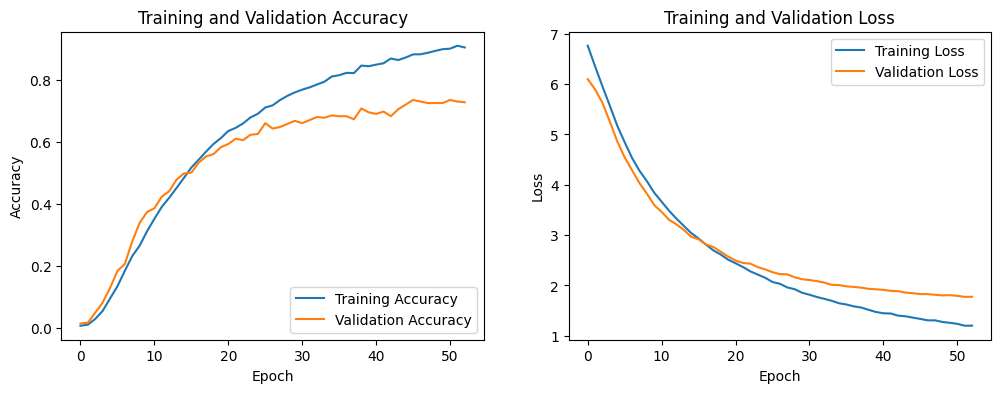

In [ ]:
import matplotlib.pyplot as plt

# Extract values from the history object
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(len(acc))

# Plot accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

# Plot loss
plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

#### 3.2.4 Evaluation using test set

In [ ]:
# Load the saved best model
model = load_model("/content/drive/MyDrive/Coursework_chatwipa/TASK 2/Model/task2_best_model6.keras")

test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


182/182 ━━━━━━━━━━━━━━━━━━━━ 55s 172ms/step - accuracy: 0.6972 - loss: 1.8749
Test Loss: 1.8833
Test Accuracy: 0.7018


In [ ]:
predictions = model.predict(test_generator, steps=len(test_generator))
predicted_classes = np.argmax(predictions, axis=1)

# Get true labels from the generator
true_classes = test_generator.classes
class_labels = list(test_generator.class_indices.keys())

print(classification_report(true_classes, predicted_classes, target_names=class_labels))

182/182 ━━━━━━━━━━━━━━━━━━━━ 45s 179ms/step
                                    precision    recall  f1-score   support

        001.Black_footed_Albatross       0.61      0.57      0.59        30
              002.Laysan_Albatross       0.63      0.63      0.63        30
               003.Sooty_Albatross       0.43      0.82      0.57        28
             004.Groove_billed_Ani       0.70      0.77      0.73        30
                005.Crested_Auklet       1.00      0.79      0.88        14
                  006.Least_Auklet       0.83      0.91      0.87        11
               007.Parakeet_Auklet       0.84      0.91      0.88        23
             008.Rhinoceros_Auklet       0.52      0.72      0.60        18
              009.Brewer_Blackbird       0.52      0.45      0.48        29
          010.Red_winged_Blackbird       0.93      0.87      0.90        30
               011.Rusty_Blackbird       0.54      0.50      0.52        30
       012.Yellow_headed_Blackbird       0.

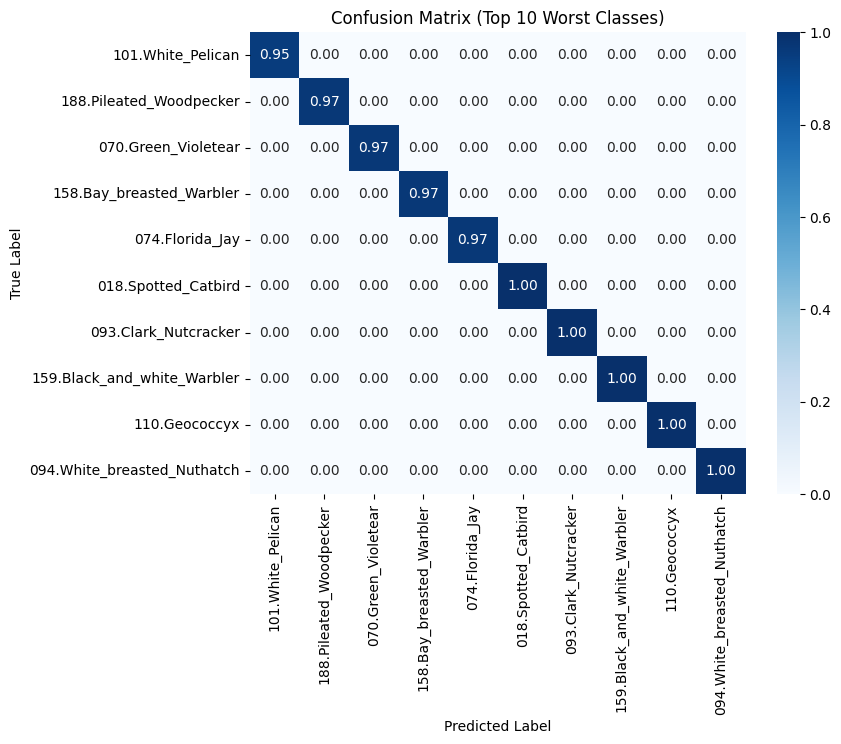

In [ ]:
# Compute confusion matrix (normalized by true class)
cm = confusion_matrix(true_classes, predicted_classes, normalize='true')

# Compute per-class TP
tp_per_class = np.diag(cm)

# Get 10 worst-performing classes (lowest recall)
top_10_classes = np.argsort(tp_per_class)[-10:]
cm_top10 = cm[np.ix_(top_10_classes, top_10_classes)]
label_top10 = [class_labels[i] for i in top_10_classes]

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_top10, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=label_top10, yticklabels=label_top10,
            vmin=0, vmax=1)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Top 10 Worst Classes)")
plt.show()

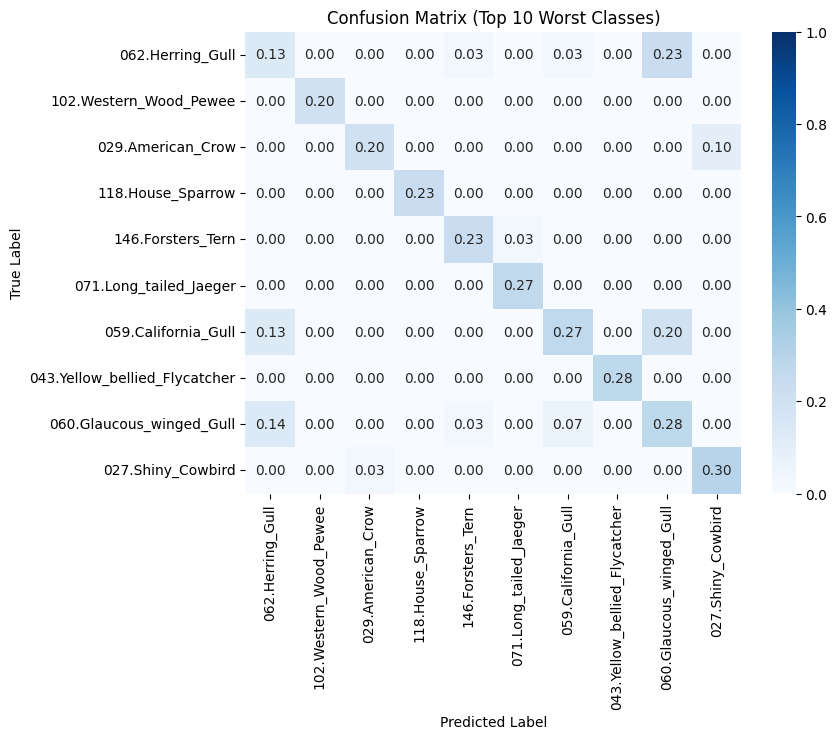

In [ ]:
# Compute confusion matrix (normalized by true class)
cm = confusion_matrix(true_classes, predicted_classes, normalize='true')

# Compute per-class TP
tp_per_class = np.diag(cm)

# Get 10 worst-performing classes (lowest true positive rate)
worst_10_classes = np.argsort(tp_per_class)[:10]
cm_worst10 = cm[np.ix_(worst_10_classes, worst_10_classes)]
label_worst10 = [class_labels[i] for i in worst_10_classes]

# Plot heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm_worst10, annot=True, fmt=".2f", cmap="Blues",
            xticklabels=label_worst10, yticklabels=label_worst10,
            vmin=0, vmax=1)
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix (Top 10 Worst Classes)")
plt.show()

## 4. Report

**Types of Approach**

1. Data Augmentation
  - Normalize pixel values from [0, 255] to [0, 1]
  - Apply geometric transformations: random rotation, width/height shifts, shear, random zoom, and random horizontal flip
  - Fill missing pixels using nearest interpolation

2. CNN-based Models
  - EfficientNetB2
    - Used transfer learning from ImageNet to reduce training time and improve accuracy
    - Achieved an average accuracy of 68% on the test dataset
    - The training and validation accuracy and loss plots suggest that this model is potential overfitting in some classes
    - Although this model is efficient and has lower computational costs, it may underperform on small datasets due to its aggressive downsampling
  - DenseNet121
    - Used transfer learning from ImageNet to reduce training time and improve accuracy
    - Performed slightly better, with an average accuracy of 70% in the test dataset
    - The training and validation accuracy follow a similar trend, show no significant signs of overfitting
    - This model can improve the performance because it reuse the feature across each layer, allowing deeper layers to retain and refine important details.

3. Optimizer Selection
  - Compared Adam and Adagrad optimizers
  - Adagrad provided the best performance on this dataset since it dynamically adjusts the learning rate for each parameter

4. Hyperparameters tuning
  - Experimented with number of unfreezing layers to optimize performance
  - Adjusted the number of units in CNN layers to optimize performance

---

**Performance Improvement Techniques (Ordered from Most to Least Impactful)**

1. Optimizer selection
    - The experiments show that the optimizer choice significantly impacts this dataset due to the low number of images per class, which affects the convergence rate and overall performance.
    - With the Adam optimizer, the model struggled to improve accuracy. In contrast, the Adagrad optimizer outperformed Adam and led to faster convergence.

2. Hyperparameter tuning and transfer learning
    - The combination of parameters such as the number of units, learning rate, batch size, and number of epochs greatly influences model efficiency. Thus, hyperparameter tuning is a critical technique for improving model performance.
    - Additionally, leveraging transfer learning with ImageNet weights and fine-tuning the pre-trained model's layers can significantly boost accuracy.

3. Model architecture adjustment
      - Experimenting with deeper architectures can help address underfitting
      - Applying batch normalization, dropout, or a global average pooling layer can prevent overfitting
      
4. Data augmentation
    - Increasing dataset diversity through data augmentation improves model generalization (prevent overfitting in some classes)

5. Batch size adjustment
    - Choosing an optimal batch size helps balance training speed and model accuracy

## 5. Demonstration



Install Library

In [1]:
!pip install keras-tuner

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 2.2 MB/s eta 0:00:00


In [2]:
import os
import zipfile
import pandas as pd
import numpy as np
import shutil
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.layers import Dense, Flatten, Dropout, GlobalAveragePooling2D, BatchNormalization
from tensorflow.keras.applications import EfficientNetB2, DenseNet121
from tensorflow.keras.optimizers import Adagrad, Adam
from tensorflow.keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint
from tensorflow.keras.regularizers import l2
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.preprocessing import image
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import keras_tuner as kt

### 5.1  Model testing

Show Deep Learning network code along with the mechanisms to read in the test data and some sample images for final testing.

Data preparation

In [4]:
# Mount the drive with google colab notebook
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
# Unzip dataset from drive to disk
dataset_zip = "/content/drive/MyDrive/Coursework_chatwipa/TASK 2/bird_CUB_200_2011.zip"
with zipfile.ZipFile(dataset_zip, 'r') as zip_ref:
    zip_ref.extractall("/content/")

In [6]:
# Read train and test label from .txt file
train_test_label = "/content/CUB_200_2011/train_test_split.txt"
split_label = pd.read_csv(train_test_label, header = None, delimiter=' ')
split_label.columns = ['label', 'is_train']

# Read the map of label number and file name from .txt file
image_name_label = "/content/CUB_200_2011/images.txt"
img_label = pd.read_csv(image_name_label, header = None, delimiter=' ')
img_label.columns = ['label', 'file_name']

# Merge the two dataframes on 'file_name'
df_merged = pd.merge(split_label, img_label, on="label")
df_merged["class_name"] = df_merged["file_name"].apply(lambda x: x.split("/")[0])

# Display the result
df_merged.head()

label  is_train                                          file_name  \
0      1         0  001.Black_footed_Albatross/Black_Footed_Albatr...   
1      2         1  001.Black_footed_Albatross/Black_Footed_Albatr...   
2      3         0  001.Black_footed_Albatross/Black_Footed_Albatr...   
3      4         1  001.Black_footed_Albatross/Black_Footed_Albatr...   
4      5         1  001.Black_footed_Albatross/Black_Footed_Albatr...   

                   class_name  
0  001.Black_footed_Albatross  
1  001.Black_footed_Albatross  
2  001.Black_footed_Albatross  
3  001.Black_footed_Albatross  
4  001.Black_footed_Albatross

In [7]:
# Function to randomly select the validation data
# (make sure that all classes have validation data)
def pick_validation(group, val_ratio = 0.1):
    n_val = max(1, int(len(group) * val_ratio)) # number of total validation number
    val_indices = np.random.choice(group.index, size=n_val, replace=False) # randomly select the index by group
    group.loc[val_indices, "is_val"] = 1 # change the label from 0 (False) to 1 (True)
    return group

df_merged["is_val"] = 0 # Setting initial label to be 0 (False)
df_merged = df_merged.groupby("class_name", group_keys=False).apply(pick_validation) # group by class and select validaion data

# Show first five rows
df_merged.head()

<ipython-input-7-3e515e2281a6>:10: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  df_merged = df_merged.groupby("class_name", group_keys=False).apply(pick_validation) # group by class and select validaion data


label  is_train                                          file_name  \
0      1         0  001.Black_footed_Albatross/Black_Footed_Albatr...   
1      2         1  001.Black_footed_Albatross/Black_Footed_Albatr...   
2      3         0  001.Black_footed_Albatross/Black_Footed_Albatr...   
3      4         1  001.Black_footed_Albatross/Black_Footed_Albatr...   
4      5         1  001.Black_footed_Albatross/Black_Footed_Albatr...   

                   class_name  is_val  
0  001.Black_footed_Albatross       0  
1  001.Black_footed_Albatross       0  
2  001.Black_footed_Albatross       0  
3  001.Black_footed_Albatross       0  
4  001.Black_footed_Albatross       1

In [8]:
# List of related folder for this project
original_folder = "/content/CUB_200_2011/images/"
train_folder = '/content/train_images/'
test_folder = '/content/test_images/'
validate_folder = '/content/validate_images/'

# Create train and test folders if not exist
os.makedirs(train_folder, exist_ok=True)
os.makedirs(test_folder, exist_ok=True)
os.makedirs(validate_folder, exist_ok=True)

# Loop through each row and move images to the correct folder
for _, row in df_merged.iterrows():
    class_name = row["class_name"]
    source_path = os.path.join(original_folder, row["file_name"])

    # Define destination folder based on is_train and is_val flag
    if row["is_train"] == 1:
      if row["is_val"] == 1:
        dest_folder = os.path.join(validate_folder, class_name)
      else:
        dest_folder = os.path.join(train_folder, class_name)
    else:
        dest_folder = os.path.join(test_folder, class_name)

    # Create class-specific subfolder if it doesn't exist
    os.makedirs(dest_folder, exist_ok=True)

    # Copy image to new location
    dest_path = os.path.join(dest_folder, os.path.basename(row["file_name"]))
    shutil.copy(source_path, dest_path)

In [9]:
# Image data generator for train data (with augmentation)
train_datagen = ImageDataGenerator(
    rescale=1./255, # Normalize pixel values to [0, 1]
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',
    validation_split=0.1
)

# Train generator (90% of data)
train_generator = train_datagen.flow_from_directory(
    train_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=True,
    subset="training"
)

# Image data generator for validation and test set (without augmentation)
test_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.1)

# Validation generator (10% of data)
validation_generator = test_datagen.flow_from_directory(
    train_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False,
    subset="validation"
)

# Test generator
test_generator = test_datagen.flow_from_directory(
    test_folder,
    target_size=(224, 224),
    batch_size=32,
    class_mode="categorical",
    shuffle=False
)

# Check one batch of images and labels
images, labels = next(train_generator)

print(f"Batch shape: {images.shape}")  # (batch_size, 224, 224, 3)
print(f"Labels shape: {labels.shape}")  # (batch_size, num_classes)

Found 5002 images belonging to 200 classes.
Found 404 images belonging to 200 classes.
Found 5794 images belonging to 200 classes.
Batch shape: (32, 224, 224, 3)
Labels shape: (32, 200)


#### 5.1.1 Test model with test dataset

In [10]:
# Load the saved best model
model = load_model("/content/drive/MyDrive/Coursework_chatwipa/TASK 2/Model/task2_best_model6.keras")

test_loss, test_accuracy = model.evaluate(test_generator, steps=len(test_generator))
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


182/182 ━━━━━━━━━━━━━━━━━━━━ 60s 196ms/step - accuracy: 0.6972 - loss: 1.8749
Test Loss: 1.8833
Test Accuracy: 0.7018


Visualization

1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step


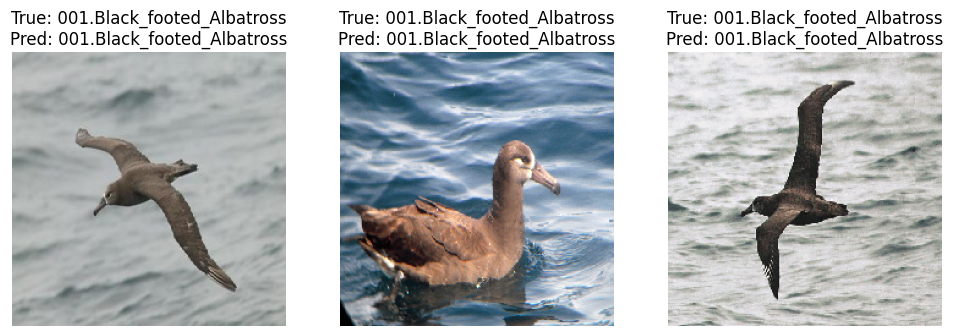

In [11]:
# Get a batch of test images and labels
test_images, test_labels = next(test_generator)
test_labels = np.argmax(test_labels, axis=1)

# Get model predictions
predictions = model.predict(test_images)
predicted_labels = np.argmax(predictions, axis=1)

# Map indices to class names
class_names = list(test_generator.class_indices.keys())

# Display images with predictions
num_images = 3  # Number of images to display
plt.figure(figsize=(12, 6))

for i in range(num_images):
    plt.subplot(1, num_images, i + 1)
    plt.imshow(test_images[i])  # Show image
    plt.axis("off")
    true_label = class_names[test_labels[i]]
    predicted_label = class_names[predicted_labels[i]]
    plt.title(f"True: {true_label}\nPred: {predicted_label}")

plt.show()

#### 5.1.2 Test model with sample images

In [47]:
# Define path
image_path = "/content/drive/MyDrive/Coursework_chatwipa/TASK 2/Test_images"

# Load the saved best model
model = load_model("/content/drive/MyDrive/Coursework_chatwipa/TASK 2/Model/task2_best_model6.keras")

# Real labels (Extract class names from filenames)
real_label = sorted([name.split('_')[0] for name in os.listdir(image_path)])

# Preprocess function
def preprocess_test_image(img_path):
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img)/255
    img_array = np.expand_dims(img_array, axis=0)
    return img_array

# Store predictions
predictions = []
image_files = sorted(os.listdir(image_path))  # Sort filenames for consistent ordering

for img_name in image_files:
    img_path = os.path.join(image_path, img_name)
    img_array = preprocess_test_image(img_path)  # Preprocess image
    pred = model.predict(img_array)              # Get prediction
    predicted_class = np.argmax(pred, axis=1)[0] # Get predicted class index
    predictions.append(predicted_class)

# Print results
for i, img_name in enumerate(image_files):
    print(f"Image: {img_name}, Real Label: {real_label[i]}, Predicted Class: {predictions[i]+1}")

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
Image: 001_Black_Footed_Albatross_0002_55.jpg, Real Label: 001, Predicted Class: 1
Image: 033_Yellow_Billed_Cuckoo_0006_26578.jpg, Real Label: 033, Predicted Class: 31
Image: 190_Red_Cockaded_Woodpecker_0008_794753.jpg, Real Label: 190, Predicted Class: 190


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 93ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 134ms/step


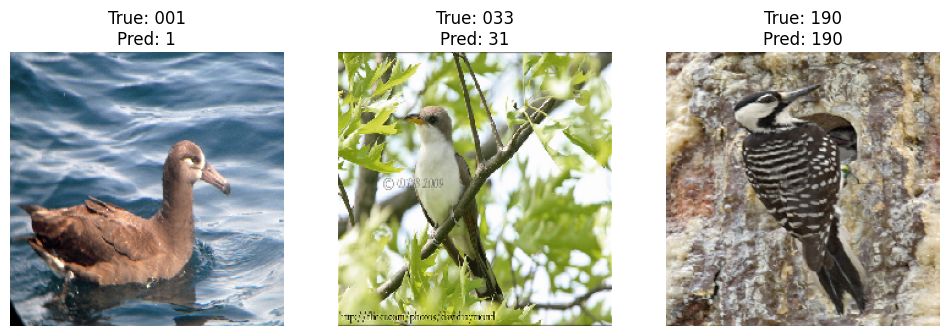

In [49]:
# Number of images to display
num_images = 3

# Sort image files to match labels
image_files = sorted(os.listdir(image_path))

# Display images with predictions
plt.figure(figsize=(12, 6))

for i, img_name in enumerate(image_files[:num_images]):
    img_path = os.path.join(image_path, img_name)

    # Load and preprocess image
    img = image.load_img(img_path, target_size=(224, 224))
    img_array = image.img_to_array(img) / 255.0  # Normalize to [0,1]

    # Make prediction
    img_batch = np.expand_dims(img_array, axis=0)  # Add batch dimension
    pred = model.predict(img_batch)
    predicted_index = np.argmax(pred, axis=1)[0]  # Get class index

    # Display image
    plt.subplot(1, num_images, i + 1)
    plt.imshow(img_array)
    plt.axis("off")

    # Labels
    true_label = real_label[i]  # True label from filename
    pred_label = predicted_index+1  # If you have class names, map index to label

    # Set title
    plt.title(f"True: {true_label}\nPred: {pred_label}")

plt.show()

### 5.2 Training 1 epoch

Show the network training for one epoch.

Model training

In [14]:
base_model = DenseNet121(weights="imagenet", include_top=False, input_shape=(224, 224, 3))

for layer in base_model.layers[-80:]:
    layer.trainable = True

# Add custom classification layers
x = GlobalAveragePooling2D()(base_model.output)
x = Dense(512, activation="relu", kernel_regularizer=l2(0.001))(x)
x = BatchNormalization()(x)
x = Dropout(0.3)(x)
x = Dense(200, activation="softmax")(x)

# Create the final model
model = Model(inputs=base_model.input, outputs=x)
model.summary()

# Compile model
model.compile(
    optimizer=Adagrad(learning_rate=0.001, clipnorm=1.0),
    loss="categorical_crossentropy",
    metrics=["accuracy"]
)

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)              ┃ Output Shape           ┃        Param # ┃ Connected to           ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)  │ (None, 224, 224, 3)    │              0 │ -                      │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d            │ (None, 230, 230, 3)    │              0 │ input_layer[0][0]      │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_conv (Conv2D)       │ (None, 112, 112, 64)   │          9,408 │ zero_padding2d[0][0]   │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_bn                  │ (None, 112, 112, 64)   │            256 │ conv1_conv[0][0]       │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv1_relu (Activation)   │ (None, 112, 112, 64)   │              0 │ conv1_bn[0][0]         │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ zero_padding2d_1          │ (None, 114, 114, 64)   │              0 │ conv1_relu[0][0]       │
│ (ZeroPadding2D)           │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ pool1 (MaxPooling2D)      │ (None, 56, 56, 64)     │              0 │ zero_padding2d_1[0][0] │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_bn         │ (None, 56, 56, 64)     │            256 │ pool1[0][0]            │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_0_relu       │ (None, 56, 56, 64)     │              0 │ conv2_block1_0_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_conv       │ (None, 56, 56, 128)    │          8,192 │ conv2_block1_0_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_bn         │ (None, 56, 56, 128)    │            512 │ conv2_block1_1_conv[0… │
│ (BatchNormalization)      │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_1_relu       │ (None, 56, 56, 128)    │              0 │ conv2_block1_1_bn[0][… │
│ (Activation)              │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_2_conv       │ (None, 56, 56, 32)     │         36,864 │ conv2_block1_1_relu[0… │
│ (Conv2D)                  │                        │                │                        │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block1_concat       │ (None, 56, 56, 96)     │              0 │ pool1[0][0],           │
│ (Concatenate)             │                        │                │ conv2_block1_2_conv[0… │
├───────────────────────────┼────────────────────────┼────────────────┼────────────────────────┤
│ conv2_block2_0_bn    

 Total params: 7,666,952 (29.25 MB)

 Trainable params: 7,582,280 (28.92 MB)

 Non-trainable params: 84,672 (330.75 KB)

In [15]:
# Dynamic change learning rate if validation loss does not improve
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=3, min_lr=1e-5)

# Early stopping (stop if no improvement)
early_stopping = EarlyStopping(monitor="val_accuracy", patience=7, restore_best_weights=True)

# Train model
history = model.fit(
    train_generator,
    validation_data = validation_generator,
    steps_per_epoch = 1, # Reduce dataset to be 32 images
    validation_steps = len(validation_generator),
    epochs = 1,
    callbacks=[reduce_lr, early_stopping]
)

1/1 ━━━━━━━━━━━━━━━━━━━━ 246s 246s/step - accuracy: 0.0000e+00 - loss: 6.5161 - val_accuracy: 0.0050 - val_loss: 6.3613 - learning_rate: 0.0010
